**1 - Introduction**



The immune system is typically divided into two categories,
innate and adaptive. Innate immunity involves nonspecific
defense mechanisms that act immediately or within hours
after a microbe appearance in the body. In contrast,
adaptive immunity is only present in vertebrates and it is
highly specific. In fact, the adaptive immune system is able
to recognize and destroy invading pathogens individually.

Adaptive immunity is articulated by lymphocytes, more
specifically by B- and T-cells, which are responsible for the humoral and cell-mediated immunity. B- and T-cells do
not recognize pathogens as a whole, but molecular components known as antigens. These antigens are recognized by
specific receptors present in the cell surface of B- and Tcells


B-cell epitopes are the sections of the antigen which interact with the BCR. They are generally classified into two categories: linear and conformational. Linear epitopes consist of consecutive peptides in the antigen’s polypeptide chain that are on the exterior of the antigens, solvent-exposed. Conformational epitopes are solvent-exposed peptides that are discontinuous in the peptide sequence. Although around 90% of epitopes are discontinuous, linear B-cell epitopes can be readily used as candidates for a vaccine


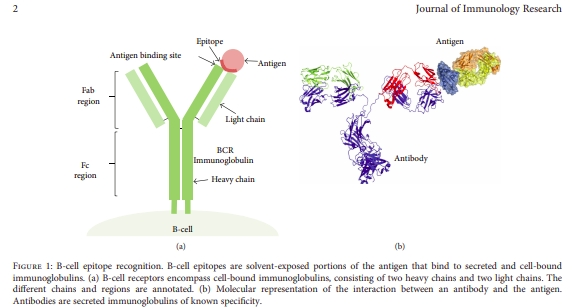

**2- Analyzing the Immune Epitope Database (IEDB)**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/epitope-prediction')  

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
for dirname, _, filenames in os.walk('./input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./input/input_covid.csv
./input/input_bcell.csv
./input/input_sars.csv



*   input_bcell.csv : this is the main training data. 
*   input_sars.csv : this is also the main training data. 
*   input_covid.csv : this is the target data. There is no label data in columns.



In [3]:
import pandas as pd 

# Importing the dataset
bcell = pd.read_csv('./input/input_bcell.csv')

bcell.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,165,SASFT,1.016,0.703,1.018,2.22,5.810364,0.103275,-0.143829,40.273300,1
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,255,LCLKI,0.770,0.179,1.199,-3.86,6.210876,0.065476,-0.036905,24.998512,1
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,149,AHRET,0.852,3.427,0.960,4.28,8.223938,0.091787,0.879227,27.863333,1
3,O84462,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,152,156,SNYDD,1.410,2.548,0.936,6.32,4.237976,0.044776,-0.521393,30.765373,1
4,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,85,89,DGTYR,1.214,1.908,0.937,4.64,6.867493,0.103846,-0.578846,21.684615,1


In [4]:
sars = pd.read_csv('./input/input_sars.csv')  

In [5]:
sars.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1,17,MFIFLLFLTLTSGSDLD,0.887,0.040,1.056,-2.159,5.569763,0.116335,-0.061116,33.205116,0
1,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1,15,MFIFLLFLTLTSGSD,0.869,0.047,1.056,-2.500,5.569763,0.116335,-0.061116,33.205116,0
2,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,2,10,FIFLLFLTL,0.621,0.042,1.148,-7.467,5.569763,0.116335,-0.061116,33.205116,0
3,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,6,20,LFLTLTSGSDLDRCT,1.021,0.230,1.049,0.927,5.569763,0.116335,-0.061116,33.205116,0
4,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,9,25,TLTSGSDLDRCTTFDDV,1.089,0.627,1.015,3.165,5.569763,0.116335,-0.061116,33.205116,0


In [7]:
bs

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,165,SASFT,1.016,0.703,1.018,2.220,5.810364,0.103275,-0.143829,40.273300,1
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,255,LCLKI,0.770,0.179,1.199,-3.860,6.210876,0.065476,-0.036905,24.998512,1
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,149,AHRET,0.852,3.427,0.960,4.280,8.223938,0.091787,0.879227,27.863333,1
3,O84462,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,152,156,SNYDD,1.410,2.548,0.936,6.320,4.237976,0.044776,-0.521393,30.765373,1
4,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,85,89,DGTYR,1.214,1.908,0.937,4.640,6.867493,0.103846,-0.578846,21.684615,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14902,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1231,1245,SCGSCCKFDEDDSEP,1.227,0.503,1.035,4.907,5.569763,0.116335,-0.061116,33.205116,0
14903,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1234,1255,SCCKFDEDDSEPVLKGVKLHYT,1.047,0.606,1.064,2.577,5.569763,0.116335,-0.061116,33.205116,0
14904,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1236,1255,CKFDEDDSEPVLKGVKLHYT,1.021,1.361,1.049,2.440,5.569763,0.116335,-0.061116,33.205116,1
14905,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1236,1250,CKFDEDDSEPVLKGV,1.051,0.886,1.042,3.127,5.569763,0.116335,-0.061116,33.205116,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


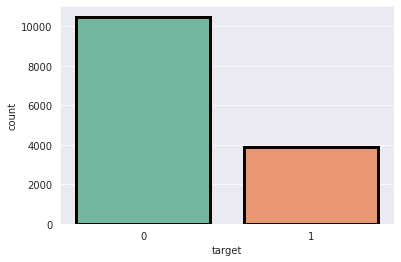

In [8]:
import seaborn as sns #visualization
# checking number of positves and negatives
sns.set_style('darkgrid')
sns.countplot(bcell['target'],linewidth=3,palette="Set2",edgecolor='black')

In [9]:
bcell.target.value_counts()

0    10485
1     3902
Name: target, dtype: int64

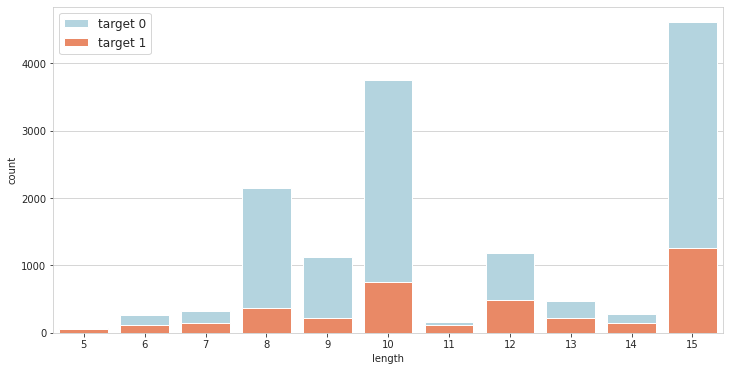

In [32]:
import matplotlib.pylab as plt

covid = pd.read_csv('./input/input_covid.csv')

# create length columns for all datasets
for df in [bcell, sars, covid]:
    df["length"] = df["end_position"] - df["start_position"] + 1

# Analyzing only the bcell dataset
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(bcell["length"], ax=ax, color="lightblue")
sns.countplot(bcell.query("target == 1")["length"], ax=ax, color="coral")
plt.legend(labels=["target 0", "target 1"], fontsize=12)
plt.show()

In [33]:
# Only the b cell dataset is being used on this notebook for training and the covid dataset for testing (the sars dataset is not used for training)
bcell

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,target,length
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,165,SASFT,1.016,0.703,1.018,2.220,5.810364,0.103275,-0.143829,40.273300,1,5
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,255,LCLKI,0.770,0.179,1.199,-3.860,6.210876,0.065476,-0.036905,24.998512,1,5
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,149,AHRET,0.852,3.427,0.960,4.280,8.223938,0.091787,0.879227,27.863333,1,5
3,O84462,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,152,156,SNYDD,1.410,2.548,0.936,6.320,4.237976,0.044776,-0.521393,30.765373,1,5
4,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,85,89,DGTYR,1.214,1.908,0.937,4.640,6.867493,0.103846,-0.578846,21.684615,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14382,Q91DE1,MDRGTRRIWVSQNQGDTDLDYHKILTAGLTVQQGIVRQKIISVYLV...,177,191,QVHAEQGLIQYPTAW,0.910,0.175,1.054,0.820,4.894836,0.071719,-0.701083,46.875237,0,15
14383,Q91DE1,MDRGTRRIWVSQNQGDTDLDYHKILTAGLTVQQGIVRQKIISVYLV...,285,299,SSLAKHGEYAPFARL,0.966,0.216,1.044,1.160,4.894836,0.071719,-0.701083,46.875237,0,15
14384,Q91DE1,MDRGTRRIWVSQNQGDTDLDYHKILTAGLTVQQGIVRQKIISVYLV...,189,203,TAWQSVGHMMVIFRL,0.821,0.023,1.044,-1.360,4.894836,0.071719,-0.701083,46.875237,0,15
14385,Q9QZS0,MHSKTAPRFLVFLLLTLLLLLAASPVASKGCVCKGKGQCLCAGTKG...,1479,1493,KRAHGQDLGTLGSCL,1.069,0.239,1.037,2.180,9.553040,0.044338,-0.671001,29.494308,0,15


**Understanding the dataset fields**

All of three datasets consists of information of protein and peptide:

parent_protein_id : parent protein ID

protein_seq : parent protein sequence

start_position : start position of peptide

end_position : end position of peptide

peptide_seq : peptide sequence

chou_fasman : peptide feature, β turn. Chou and Fasman developed the Chou-Fasman method to predict secondary structures using empirical rules

emini : peptide feature, relative surface accessibility. Emini Method: The calculation was based on surface accessibility scale on a product instead of an addition within the window.

kolaskar_tongaonkar : peptide feature, antigenicity. Kolaskar Method: In this method 156 antigenic determinants (< 20 amino acids) in 34 different proteins were analyzed (Kolaskar and Tongaonkar, 1990) to calculate the antigenic propensity (Ap ) of residues. 

parker : peptide feature, hydrophobicity. Parker Method: In this method, hydrophilic scale based on peptide retention times during high-performance liquid chromatography (HPLC) on a reversed-phase column was constructed (Parker et al., 1986).

isoelectric_point : protein feature. The isoelectric point of an amino acid is the point at which the amino acid has no net electrical charge

aromacity: protein feature. Aromaticity is a chemical property in which certain systems are more stable than they should be, are more symmetrical than assumed, and have a peculiar magnetic characteristic.

hydrophobicity : protein feature. Hydrophobicity is basically a measure of the degree of affinity between water and the side chain of an amino acid

stability : protein feature. Stability is the potential of a pattern to survive over time. The processes such as protein unfolding, denaturation, degradation, conformational change, enzymatic modification and proteolytic cleavage may transform this ‘pattern’.

target : antibody valence (target value). Valency of antibody means the quantity of its antigen binding sites

In [14]:
# split the data into train and test(10%)
from sklearn.model_selection import train_test_split
train, test = train_test_split(bcell, test_size=0.1)

In [15]:
# Use lib pacaret to facilitate training and compare with many linear models
!pip install pycaret

In [16]:
from pycaret.classification import *

experiment = setup(
    data = train 
    ,target = 'target'
    ,ignore_features = ['parent_protein_id', 'protein_seq', 'peptide_seq']
    ,normalize = True
    ,fix_imbalance = True
)

,Description,Value
0,session_id,2329
1,Target,target
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(12948, 15)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [17]:
# comparation between models
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8684,0.9239,0.7658,0.7525,0.7589,0.6684,0.6686,2.313
et,Extra Trees Classifier,0.8674,0.9233,0.7633,0.7511,0.7569,0.6658,0.6660,1.187
lightgbm,Light Gradient Boosting Machine,0.8474,0.9101,0.7519,0.7046,0.7272,0.6215,0.6223,0.297
dt,Decision Tree Classifier,0.8329,0.7971,0.7189,0.6820,0.6995,0.5840,0.5848,0.120
gbc,Gradient Boosting Classifier,0.7983,0.8635,0.7515,0.6020,0.6683,0.5259,0.5329,2.277
ada,Ada Boost Classifier,0.7389,0.7956,0.6866,0.5132,0.5873,0.4022,0.4114,0.630
knn,K Neighbors Classifier,0.6272,0.6346,0.5361,0.3694,0.4372,0.1724,0.1793,0.165
lr,Logistic Regression,0.6119,0.6546,0.6495,0.3746,0.4751,0.2011,0.2204,0.430
ridge,Ridge Classifier,0.6104,0.0000,0.6548,0.3742,0.4761,0.2013,0.2214,0.038
lda,Linear Discriminant Analysis,0.6103,0.6542,0.6544,0.3740,0.4759,0.2009,0.2210,0.052


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=2329, verbose=0,
                       warm_start=False)

In [18]:
from sklearn.metrics import roc_auc_score

# choose the rf as best model since it has the highest F1
best_model = ['rf']

df_Results = pd.DataFrame(columns=['Classification', 'Dataset', 'Model', 'AUC'])

for m in best_model:
    print('-----------------------------------------------------')
    print('[START] - Processing model: ', m)
    print('-----------------------------------------------------')
    
    mo = create_model(m)
        
    mo_pred = predict_model(mo, test)
    mo_pred.dropna(inplace=True)
    
    try:
        df_Results.loc[len(df_Results)] = [m, 'Valid', 'Model', roc_auc_score(mo_pred['target'], mo_pred['Label'])]
    except:
        df_Results.loc[len(df_Results)] = [m, 'Valid', 'Model', 'NA']
    
    print('-----------------------------------------------------')
    print('[FINISHED] - Model: ', m)
    print('-----------------------------------------------------')
    

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8467,0.9123,0.7429,0.7054,0.7237,0.6177,0.6181
1,0.8754,0.9312,0.8000,0.7538,0.7762,0.6900,0.6906
2,0.8809,0.9294,0.7967,0.7717,0.7840,0.7018,0.7020
3,0.8742,0.9262,0.7673,0.7673,0.7673,0.6811,0.6811
4,0.8852,0.9356,0.7796,0.7925,0.7860,0.7076,0.7076
5,0.8709,0.9234,0.7510,0.7667,0.7588,0.6706,0.6707
6,0.8543,0.9070,0.7551,0.7198,0.7371,0.6364,0.6367
7,0.8587,0.9179,0.7592,0.7294,0.7440,0.6465,0.6467
8,0.8687,0.9286,0.7510,0.7603,0.7556,0.6658,0.6659
9,0.8687,0.9269,0.7551,0.7582,0.7566,0.6667,0.6667


-----------------------------------------------------
[FINISHED] - Model:  rf
-----------------------------------------------------


In [19]:
x=bcell.drop(['target', 'parent_protein_id', 'protein_seq', 'peptide_seq'], axis=1 )
y=bcell['target']

In [23]:
#feature importance
from sklearn.ensemble import RandomForestClassifier
r =  RandomForestClassifier(random_state=0)
r.fit(x,y)
feature_importance = r.feature_importances_
feature_importance_normalized = np.std([tree.feature_importances_ for tree in 
                                        r.estimators_], 
                                        axis = 0) 

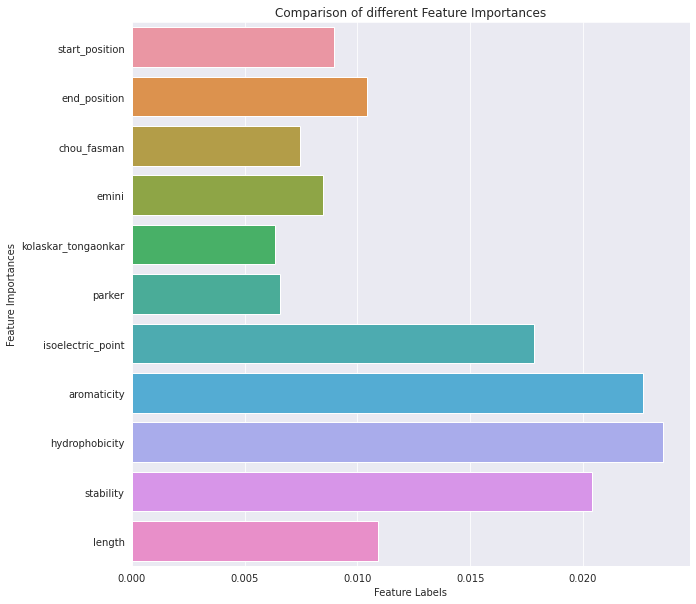

In [24]:
#importing libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px#dropping unnecessary columns
#bs.drop(columns=['parent_protein_id','protein_seq','peptide_seq'],inplace=True)
plt.figure(figsize=(10,10))
sns.barplot(feature_importance_normalized,x.columns) 
plt.xlabel('Feature Labels') 
plt.ylabel('Feature Importances') 
plt.title('Comparison of different Feature Importances') 
plt.show() 

In [ ]:
#As shown in the figure above, the most relevant features are related to the protein features and peptide length

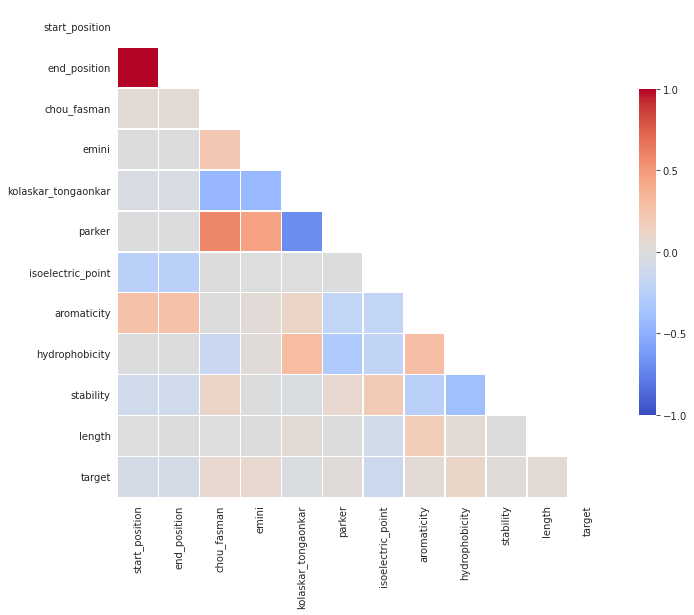

In [26]:
# Corelation Matrix
corr_matrix = bcell[
    [
        
        "start_position",
        "end_position",
        "chou_fasman",
        "emini",
        "kolaskar_tongaonkar",
        "parker",
        "isoelectric_point",
        "aromaticity",
        "hydrophobicity",
        "stability",
        "length",
        "target",
    ]
].corr()

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#corr heatmap
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sns.heatmap(corr_matrix, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = False,
                      annot_kws = {'size': 12})
#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

<Figure size 2160x2160 with 0 Axes>

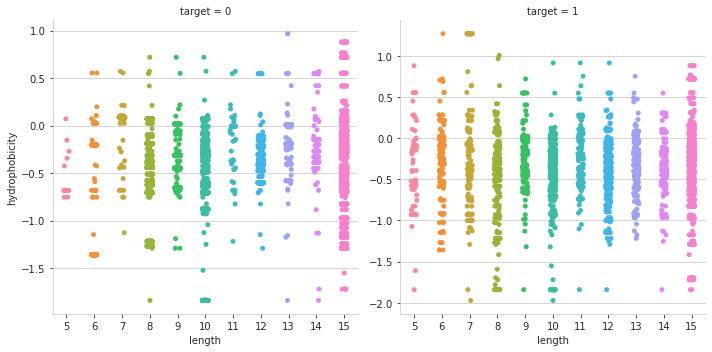

In [27]:
# Most of the peptides showing strong hydrophobicity property are at positive target than negative target
plt.figure(figsize=(30,30))
sns.catplot(y='hydrophobicity', x='length', data=bcell, ci=None, col='target', sharey=False)

<Figure size 2160x2160 with 0 Axes>

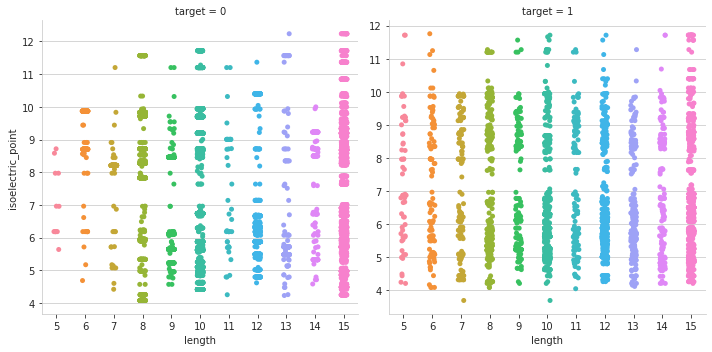

In [ ]:
# The number of peptides of length 8, 10 and 15 have strong values of isoelectric point at range above 7 at negative target. 
# Most of the values of peptide length have greater range of values below 7 
plt.figure(figsize=(30,30))
sns.catplot(y='isoelectric_point', x='length', data=bcell, ci=None, col='target', sharey=False)

<Figure size 2160x2160 with 0 Axes>

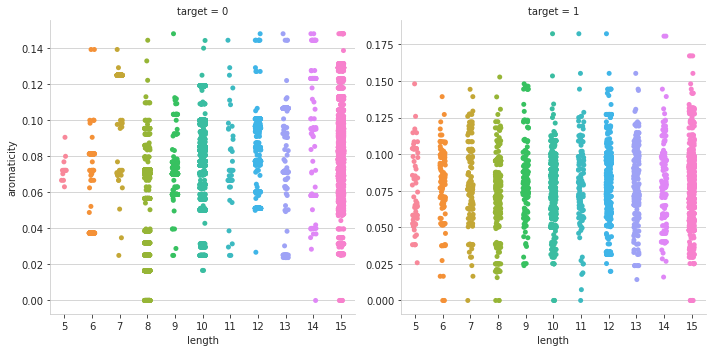

In [28]:
# Most of the peptides have range of aromaticity within range of 0.05 to 0.10 at negative target.
# Most of the peptides have range of aromaticity within range of 0.04 to 0.12 at positive target 
plt.figure(figsize=(30,30))
sns.catplot(y='aromaticity', x='length', data=bcell, ci=None, col='target', sharey=False)

<Figure size 2160x2160 with 0 Axes>

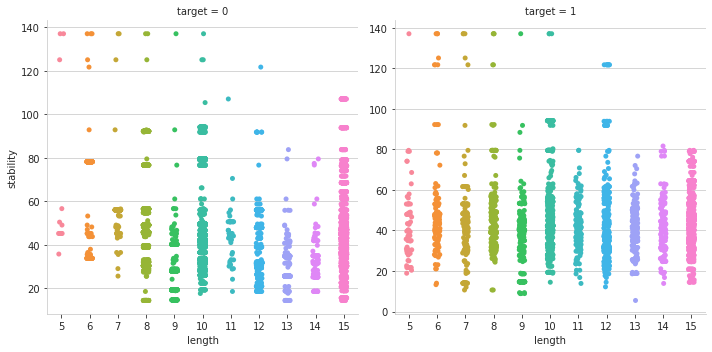

In [30]:
# Most of the peptides show stability within range 20 to 60 at positive target.
# Most of the peptides show stability within range 20 to 80 at negative target
plt.figure(figsize=(30,30))
sns.catplot(y='stability', x='length', data=bcell, ci=None, col='target', sharey=False)

**Get Covid-19 data**

In [29]:
covid = covid.drop(['parent_protein_id', 'protein_seq', 'peptide_seq'], axis=1)
covid.head()

,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,length
0,1,5,0.948,0.280,1.033,-2.72,6.03595,0.10929,-0.138642,31.377603,5
1,2,6,1.114,0.379,1.070,-0.58,6.03595,0.10929,-0.138642,31.377603,5
2,3,7,1.106,0.592,1.108,-1.30,6.03595,0.10929,-0.138642,31.377603,5
3,4,8,1.324,0.836,1.053,1.44,6.03595,0.10929,-0.138642,31.377603,5
4,5,9,1.326,1.004,0.968,2.44,6.03595,0.10929,-0.138642,31.377603,5


In [31]:
pred_covid = predict_model(mo, covid)

pred_covid


,start_position,end_position,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,length,Label,Score
0,1,5,0.948,0.280,1.033,-2.720,6.03595,0.10929,-0.138642,31.377603,5,1,0.79
1,2,6,1.114,0.379,1.070,-0.580,6.03595,0.10929,-0.138642,31.377603,5,1,0.78
2,3,7,1.106,0.592,1.108,-1.300,6.03595,0.10929,-0.138642,31.377603,5,1,0.77
3,4,8,1.324,0.836,1.053,1.440,6.03595,0.10929,-0.138642,31.377603,5,1,0.80
4,5,9,1.326,1.004,0.968,2.440,6.03595,0.10929,-0.138642,31.377603,5,1,0.87
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20307,1258,1277,0.947,0.406,1.063,0.155,6.03595,0.10929,-0.138642,31.377603,20,1,0.58
20308,1259,1278,0.937,0.353,1.061,0.355,6.03595,0.10929,-0.138642,31.377603,20,1,0.60
20309,1260,1279,0.960,0.647,1.047,0.645,6.03595,0.10929,-0.138642,31.377603,20,1,0.65
20310,1261,1280,0.960,0.449,1.058,0.540,6.03595,0.10929,-0.138642,31.377603,20,1,0.60
